#### DSFSI Covid19 - Covid Prediction
By: Tinashe Chinyati and Graeme Lubbe

#### Datasets
- covid19za_provincial_cumulative_timeline_confirmed.csv
- covid19za_provincial_cumulative_timeline_recoveries.csv
- covid19za_provincial_cumulative_timeline_deaths.csv

### Assumptions

- no one has been vaccinated
- no one has had the disease before
- there’s no way to control the spread of the disease

Another model which incorporates vaccination will be developed

# 1. Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

# data wrangling & pre-processing
import numpy as np
import pandas as pd
from pandas import datetime
import random
import math
from math import sqrt
import time
import datetime
import operator

# data visualization
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns

#model validation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 2. Loading Datasets

In [3]:
confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv')
recoveries = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv')

In [4]:
cases_58 = confirmed_cases['total'][-58:]
recoveries_58 = recoveries['total'][-58:]
deaths_58 = deaths['total'][-58:]

In [5]:
cases_np = np.array(cases_58)

In [6]:
recoveries_np = np.array(recoveries_58)

In [7]:
deaths_np = np.array(deaths_58)

In [8]:
cases_np[:-27]

array([3685121, 3686557, 3688424, 3690292, 3691963, 3693533, 3694505,
       3695176, 3696824, 3698804, 3700485, 3702043, 3703330, 3704219,
       3704785, 3705697, 3707090, 3709210, 3710767, 3712264, 3713253,
       3713834, 3715389, 3717068, 3718954, 3720646, 3722066, 3722955,
       3723640, 3725178, 3727209], dtype=int64)

### Create an array with cumulative confirmed cases, recovered and deaths for 58 days

In [9]:
# X_cml = confirmed cases
X_cml = np.array([41, 45, 62, 121, 199, 291, 440, 574, 835, 1279, 1985, 2761, 4535, 5997, 7736, 9720, 11821, 14411, 17238, 20471, 24363, 28060, 31211, 34598, 37251, 40235, 42708, 44730, 59882, 63932, 66576, 68584, 70635, 72528, 74279, 75101, 75993, 76392, 77041, 77262, 77779, 78190, 78630, 78959, 79389, 79968, 80174, 80302, 80422, 80565, 80710, 80813, 80859, 80904, 80924, 80955, 80980, 81003, 81201, 81048, 81077, 81116, 81151, 81235, 81300, 81416, 81498, 81600, 81747, 81846, 81960, 82078, 82213, 82341, 82447, 82545, 82631, 82724, 82802, 82875, 82930, 83005, 83071, 83157, 83249], dtype=np.float64)[:-27]
# recovered 
recovered = np.array([12, 12, 16, 21, 25, 25, 28, 28, 34, 38, 49, 51, 60, 103, 124, 171, 243, 328, 475, 632, 892, 1153, 1540, 2050, 2651, 3283, 3998, 4742, 5915, 6728, 8101, 9425, 10853, 12561, 14387, 16170, 18279, 20673, 22907, 24757, 27353, 29775, 32531, 36157, 39049, 41675, 44518, 47260, 49914, 52109, 53793, 55477, 57143, 58684, 59982, 61567, 62887, 64216, 65649, 67022, 67863, 68799, 69725, 70547, 71284, 71876, 72382, 72841, 73299, 73791, 74196, 74737, 75122, 75600, 75937, 76225, 76415, 76610, 76785, 76984, 77210, 77348, 77450, 77586, 77711], dtype=np.float64)[:-27]
# death 
death = np.array([2, 3, 3, 3, 4, 6, 9, 18, 25, 41, 56, 80, 106, 132, 170, 213, 259, 304, 361, 425, 491, 564, 637, 723, 812, 909, 1017, 1114, 1368, 1381, 1524, 1666, 1772, 1870, 2006, 2121, 2239, 2348, 2445, 2595, 2666, 2718, 2747, 2791, 2838, 2873, 2915, 2946, 2984, 3015, 3045, 3073, 3100, 3123, 3140, 3162, 3173, 3180, 3194, 3204, 3218, 3231, 3242, 3250, 3253, 3261, 3267, 3276, 3283, 3287, 3293, 3298, 3301, 3306, 3311, 3314, 3321, 3327, 3331, 3335, 3338, 3340, 3340, 3342, 3344], dtype=np.float64)[:-27]
# Population: Population for SA was taken from https://www.worldometers.info/world-population/south-africa-population/
population = 60695788

In [10]:
len(death)

58

## SIR MODEL

In [11]:
def data_spilt(data, orders, start):
    x_train = np.empty((len(data) - start - orders, orders))
    y_train = data[start + orders:]

    for i in range(len(data) - start - orders):
        x_train[i] = data[i + start:start + orders + i]

    # Exclude the day (Feb. 12, 2020) of the change of the definition of confirmed cases in Hubei China.
    x_train = np.delete(x_train, np.s_[28 - (orders + 1) - start:28 - start], 0)
    y_train = np.delete(y_train, np.s_[28 - (orders + 1) - start:28 - start])

    return x_train, y_train

### Search for best parameters

In [12]:
def ridge(x, y):
    print('\nStart searching good parameters for the task...')
    parameters = {'alpha': np.arange(0, 0.100005, 0.000005).tolist(),
                  "tol": [1e-8],
                  'fit_intercept': [True, False],
                  'normalize': [True, False]}

    clf = GridSearchCV(Ridge(), parameters, n_jobs=-1, cv=5)
    clf.fit(x, y)

    print('\nResults for the parameters grid search:')
    print('Model:', clf.best_estimator_)
    print('Score:', clf.best_score_)

    return clf

In [13]:
cases_np

array([3685121, 3686557, 3688424, 3690292, 3691963, 3693533, 3694505,
       3695176, 3696824, 3698804, 3700485, 3702043, 3703330, 3704219,
       3704785, 3705697, 3707090, 3709210, 3710767, 3712264, 3713253,
       3713834, 3715389, 3717068, 3718954, 3720646, 3722066, 3722955,
       3723640, 3725178, 3727209, 3728690, 3730067, 3731248, 3732076,
       3732629, 3733920, 3735579, 3737347, 3739193, 3740399, 3741231,
       3742108, 3743583, 3746425, 3750831, 3755460, 3759690, 3762912,
       3764866, 3769927, 3776299, 3780445, 3785399, 3791926, 3795764,
       3798414, 3802199], dtype=int64)

In [14]:
########## data preprocess ##########
#   N = total number of population
#   beta = transition rate S->I
#   gamma = transition rate I->R
#   R0 = is defined as the expected number of secondary cases produced by a 
#   single (typical) infection in a completely susceptible population

X = cases_np[:] - recoveries_np[:] - deaths_np[:]
R = recoveries_np[:] + deaths_np[:]

n = np.array([population] * len(X), dtype=np.float64)

S = n - X - R

X_diff = np.array([X[:-1], X[1:]], dtype=np.float64).T
R_diff = np.array([R[:-1], R[1:]], dtype=np.float64).T

gamma = (R[1:] - R[:-1]) / X[:-1]
beta = n[:-1] * (X[1:] - X[:-1] + R[1:] - R[:-1]) / (X[:-1] * (n[:-1] - X[:-1] - R[:-1]))
R0 = beta / gamma

- R0 tells you the average number of people who will contract a contagious disease from one person with that disease. It specifically applies to a population of people who were previously free of infection and haven’t been vaccinated.
- If R0 is less than 1, each existing infection causes less than one new infection. In this case, the disease will decline and eventually die out.
- If R0 equals 1, each existing infection causes one new infection. The disease will stay alive and stable, but there won’t be an outbreak or an epidemic.
- If R0 is more than 1, each existing infection causes more than one new infection. The disease will be transmitted between people, and there may be an outbreak or epidemic.

In [15]:
########## Parameters for Ridge Regression ##########

from sklearn.linear_model import Ridge
orders_beta = 3
orders_gamma = 3

##### Select a starting day for the data training in the ridge regression. #####
start_beta = 10
start_gamma = 10

########## Print Info ##########
print("\nThe latest transmission rate beta of SIR model:", beta[-1])
print("The latest recovering rate gamma of SIR model:", gamma[-1])
print("The latest basic reproduction number R0:", R0[-1])

########## Ridge Regression ##########
##### Split the data to the training set and testing set #####
x_beta, y_beta = data_spilt(beta, orders_beta, start_beta)
x_gamma, y_gamma = data_spilt(gamma, orders_gamma, start_gamma)

##### Training and Testing #####
clf_beta = Ridge(alpha=0.003765, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_beta, y_beta)
clf_gamma = Ridge(alpha=0.001675, copy_X=True, fit_intercept=False, max_iter=None,normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_gamma, y_gamma)

beta_hat = clf_beta.predict(x_beta)
gamma_hat = clf_gamma.predict(x_gamma)


The latest transmission rate beta of SIR model: 0.08705843079753427
The latest recovering rate gamma of SIR model: 0.21511891157635998
The latest basic reproduction number R0: 0.4046991041353956


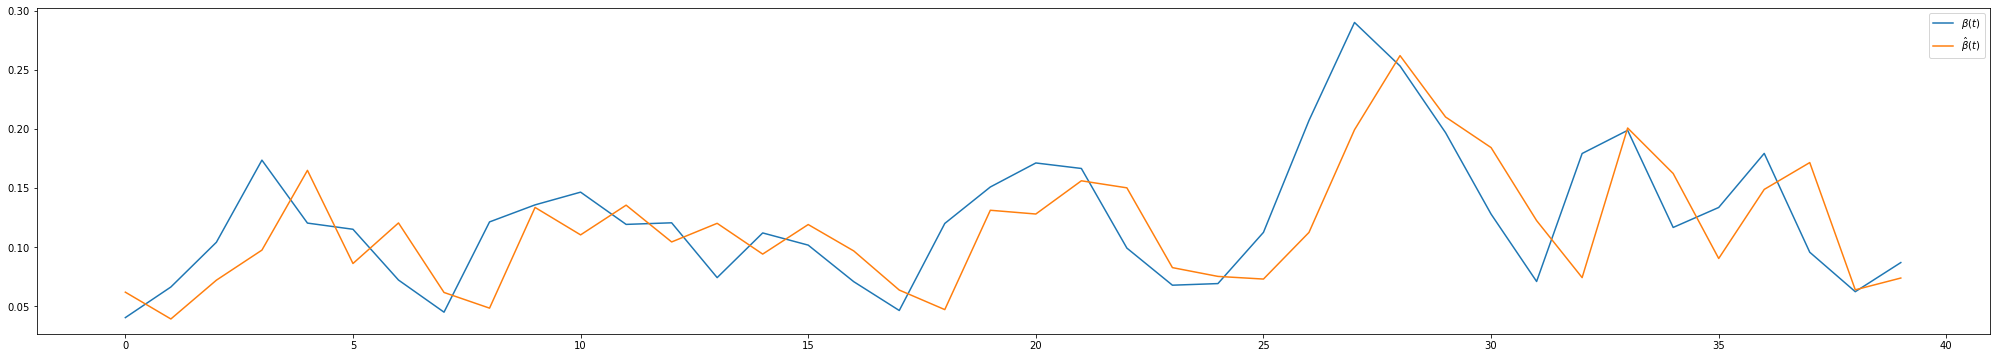

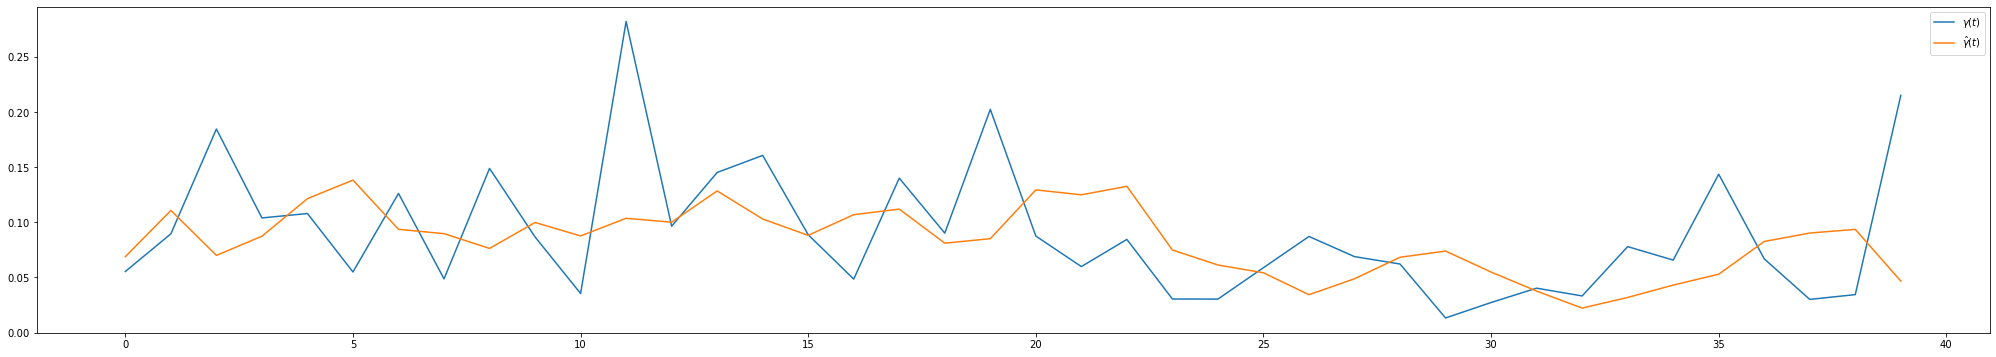

In [16]:
##### Plot the training and testing results #####
plt.figure(figsize=(35,6))
plt.figure(1)
plt.plot(y_beta, label=r'$\beta (t)$')
plt.plot(beta_hat, label=r'$\hat{\beta}(t)$')
plt.legend()

plt.figure(figsize=(35,6))
plt.figure(2)
plt.plot(y_gamma, label=r'$\gamma (t)$')
plt.plot(gamma_hat, label=r'$\hat{\gamma}(t)$')
plt.legend()

In [17]:
########## Time-dependent SIR model ##########

##### Parameters for the Time-dependent SIR model #####
stop_X = 0 # stopping criteria
stop_day = 100 # maximum iteration days 

day_count = 0
turning_point = 0

S_predict = [S[-1]]
X_predict = [X[-1]]
R_predict = [R[-1]]

predict_beta = np.array(beta[-orders_beta:]).tolist()
predict_gamma = np.array(gamma[-orders_gamma:]).tolist()
while (X_predict[-1] >= stop_X) and (day_count <= stop_day):
    if predict_beta[-1] > predict_gamma[-1]:
        turning_point += 1

    next_beta = clf_beta.predict(np.asarray([predict_beta[-orders_beta:]]))[0]
    next_gamma = clf_gamma.predict(np.asarray([predict_gamma[-orders_gamma:]]))[0]

    if next_beta < 0:
        next_beta = 0
    if next_gamma < 0:
        next_gamma = 0

    predict_beta.append(next_beta)
    predict_gamma.append(next_gamma)

    next_S = ((-predict_beta[-1] * S_predict[-1] *
               X_predict[-1]) / n[-1]) + S_predict[-1]
    next_X = ((predict_beta[-1] * S_predict[-1] * X_predict[-1]) /
              n[-1]) - (predict_gamma[-1] * X_predict[-1]) + X_predict[-1]
    next_R = (predict_gamma[-1] * X_predict[-1]) + R_predict[-1]

    S_predict.append(next_S)
    X_predict.append(next_X)
    R_predict.append(next_R)

    day_count += 1

In [18]:
########## Print Information ##########
print('\nConfirmed cases tomorrow:', np.rint(X_predict[1] + R_predict[1]))
print('Infected persons tomorrow:', np.rint(X_predict[1]))
print('Recovered + Death persons tomorrow:', np.rint(R_predict[1]))

print('\nEnd day:', day_count)
print('Confirmed cases on the end day:', np.rint(X_predict[-2] + R_predict[-2]))

print('\nTuring point:', turning_point)


Confirmed cases tomorrow: 3805749.0
Infected persons tomorrow: 41233.0
Recovered + Death persons tomorrow: 3764516.0

End day: 101
Confirmed cases on the end day: 3836755.0

Turing point: 1


In [19]:
daily_cases = np.rint(X_predict[1] + R_predict[1])

In [20]:
daily_cases

3805749.0

In [39]:
previous_cases = confirmed_cases['total'][-1:].item()

In [40]:
previous_cases

3802199

### Tomorrow's cases prediction

In [41]:
differences = daily_cases - previous_cases
print(f"Predicted cases tomorrow: {differences}")

Predicted cases tomorrow: 3550.0


<Figure size 432x288 with 0 Axes>

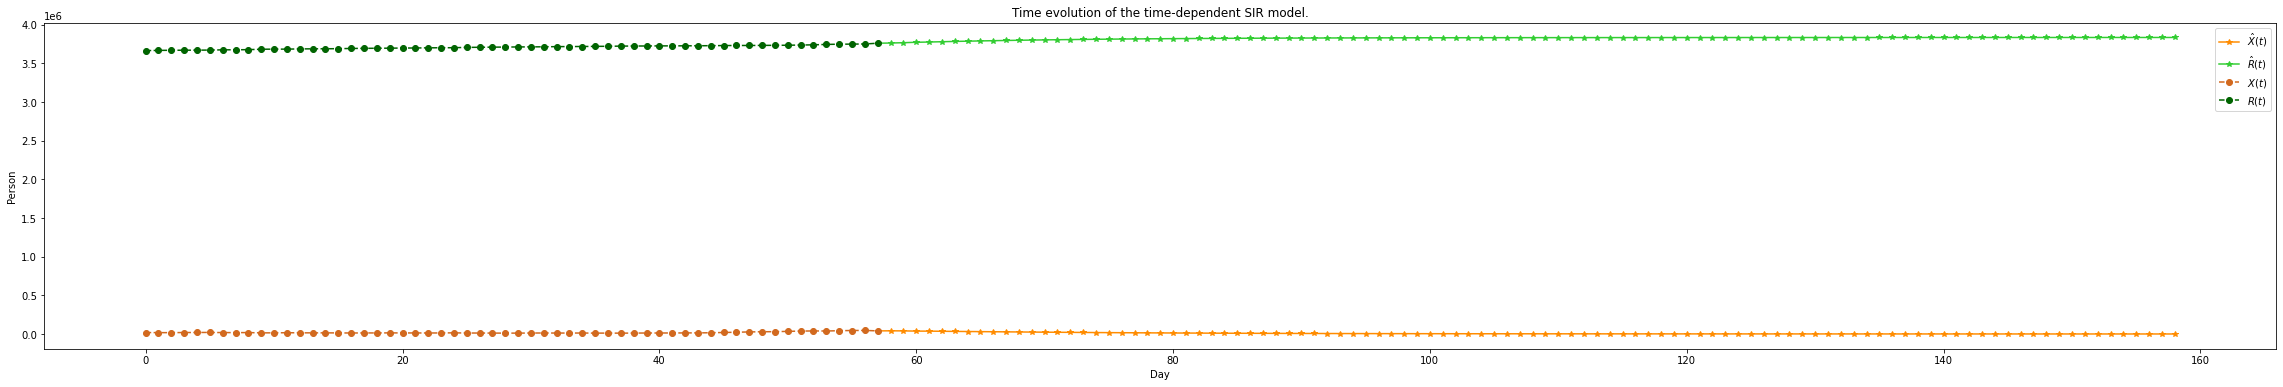

In [24]:
########## Plot the time evolution of the time-dependent SIR model ##########
plt.figure(3);
plt.figure(figsize=(40,6));
plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), X_predict, '*-', label=r'$\hat{X}(t)$', color='darkorange');
plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), R_predict, '*-', label=r'$\hat{R}(t)$', color='limegreen');
plt.plot(range(len(X)), X, 'o--', label=r'$X(t)$', color='chocolate');
plt.plot(range(len(X)), R, 'o--', label=r'$R(t)$', color='darkgreen');
plt.xlabel('Day');
plt.ylabel('Person');
plt.title('Time evolution of the time-dependent SIR model.');

plt.legend();

# plt.show()